# aSPEM Experiment : analysis


Test de différtentes pentes $k$ pour la relation entre $p_bet$ et $\hat{p}$


In [1]:
%run ../0_parameters.ipynb


WELCOME



In [2]:
import glob
import bayesianchangepoint as bcp

In [3]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)

In [4]:
from aSPEM import Analysis
e = Analysis(name_file_fit='fct_velocity_sigmo')

In [5]:
def sigmoid(y):
    return 1 / (1 + np.exp(-y))
def logit(p):
    return np.log(p / (1 - p))

/home/phantom/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/phantom/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


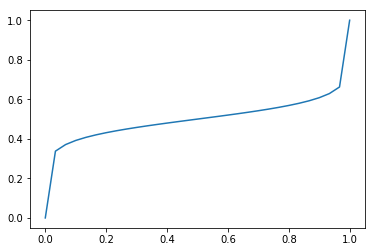

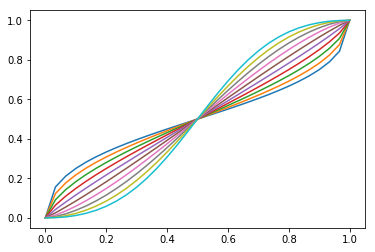

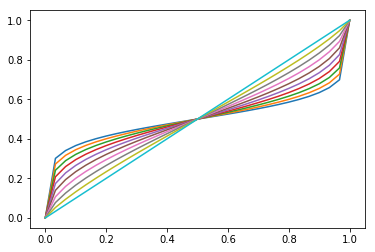

In [6]:
p = np.linspace(0, 1, 31)
plt.plot(p, sigmoid(.2*logit(p)))
plt.show()
for k in np.logspace(-1, 1, 10, base=2):
    plt.plot(p, sigmoid(k*logit(p)))
plt.show()
for k in np.logspace(-2, 0, 10, base=2):
    plt.plot(p, sigmoid(k*logit(p)))
plt.show()

In [7]:
def r_(p, data) :
    
    p = np.ma.masked_array(p, mask=np.isnan(data)).compressed()
    data = np.ma.masked_array(data, mask=np.isnan(data)).compressed()

    from scipy import stats
    slope, intercept, r_, p_value, std_err = stats.linregress(p, data)
    
    return r_

In [8]:
import pickle
file = os.path.join('parametre', 'list_r_bet_logit_600.pkl')
with open(file, 'rb') as fichier:
    recording = pickle.load(fichier, encoding='latin1')

In [9]:
Full = e.Full_list(modes_bcp=[])
modes_bcp = 'mean'
list_h = recording['list_h']

r_k_s, h_k_s = {}, {}
for num, s in enumerate(list(set(Full.sujet))):
    print(s, end=' ')
    
    bet = Full['results'][Full.sujet==s].values.tolist()
    x = np.array(Full['bino'][Full.sujet==s].values.tolist())

    r_k, h_k = [], []
    for k in range(11) : r_k.append([]) ; h_k.append([])
    
    for num, k in enumerate(np.logspace(-1, 1, 10, base=2)) :
        
        r_bet_l, r_bet_ = recording['r_bet_k'][s][k], recording['r_bet_k'][s]['sslogit']
        
        if num==0 : h_k[0]=list_h[np.argmax(r_bet_)] ; r_k[0]=np.max(r_bet_)
        h_k[num+1]=list_h[np.argmax(r_bet_l)] ; r_k[num+1]=np.max(r_bet_l)
        
    h_k_s[s], r_k_s[s] = h_k, r_k

RS LB CS YK FM DC IP OP BMC TN AM SR 

Plot de R en fonction de la pente

No handles with labels found to put in legend.
No handles with labels found to put in legend.


		sans logit|avec logit (max r)

-------------------------------------------------------------------------------------
RS	k:	         |1.000
	h(tau):	0.006(162)|0.006(162)
	r:	0.647    |0.647
-------------------------------------------------------------------------------------
LB	k:	         |0.680
	h(tau):	0.048(21)|0.053(19)
	r:	0.871    |0.873
-------------------------------------------------------------------------------------
CS	k:	         |0.500
	h(tau):	0.125(8)|0.111(9)
	r:	0.735    |0.742
-------------------------------------------------------------------------------------
YK	k:	         |0.583
	h(tau):	0.028(36)|0.032(31)
	r:	0.678    |0.680
-------------------------------------------------------------------------------------
FM	k:	         |0.500
	h(tau):	0.056(18)|0.053(19)
	r:	0.795    |0.809
-------------------------------------------------------------------------------------
DC	k:	         |0.500
	h(tau):	0.167(6)|0.167(6)
	r:	0.833    |0.834
---------------------------

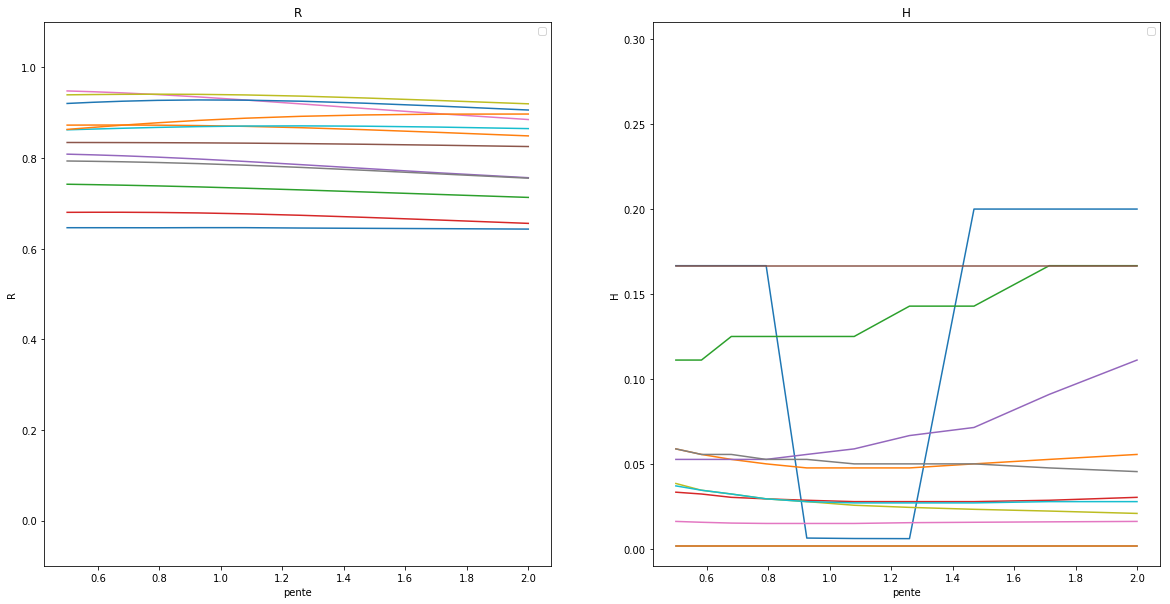

In [10]:
fig, ax = plt.subplots(1,2,figsize=(2*10,10))

list_k = np.logspace(-1, 1, 10, base=2)
print('\t\tsans logit|avec logit (max r)\n')
print('-'*85)

for num, s in enumerate(h_k_s.keys()) :
    h_k, r_k = np.array(h_k_s[s]), np.array(r_k_s[s])
    
    r_m   = np.max(r_k)
    arg_m = np.argmax(r_k)
    h_m   = h_k[arg_m]
    
    if arg_m==0 : k_m = 1
    else :       k_m = list_k[arg_m-1]
    
    print('%s\tk:\t         |%.3f'%(s, k_m))
    print('\th(tau):\t%.3f(%.0f)|%.3f(%.0f)'%(h_k[0], 1/h_k[0], h_m, 1/h_m))
    print('\tr:\t%.3f    |%.3f'%(r_k[0], r_m))
    print('-'*85)
    
    ax[0].plot(list_k, r_k[1:])
    ax[1].plot(list_k, h_k[1:])

ax[0].set_ylim(-0.1, 1.1)
ax[1].set_ylim(-0.01, 0.31)
        
ax[0].set_title('R') ; ax[1].set_title('H')
ax[0].set_ylabel('R') ; ax[1].set_ylabel('H')
for a in range(2) : ax[a].legend() ; ax[a].set_xlabel('pente')

RS LB CS YK FM DC IP OP BMC TN AM SR 

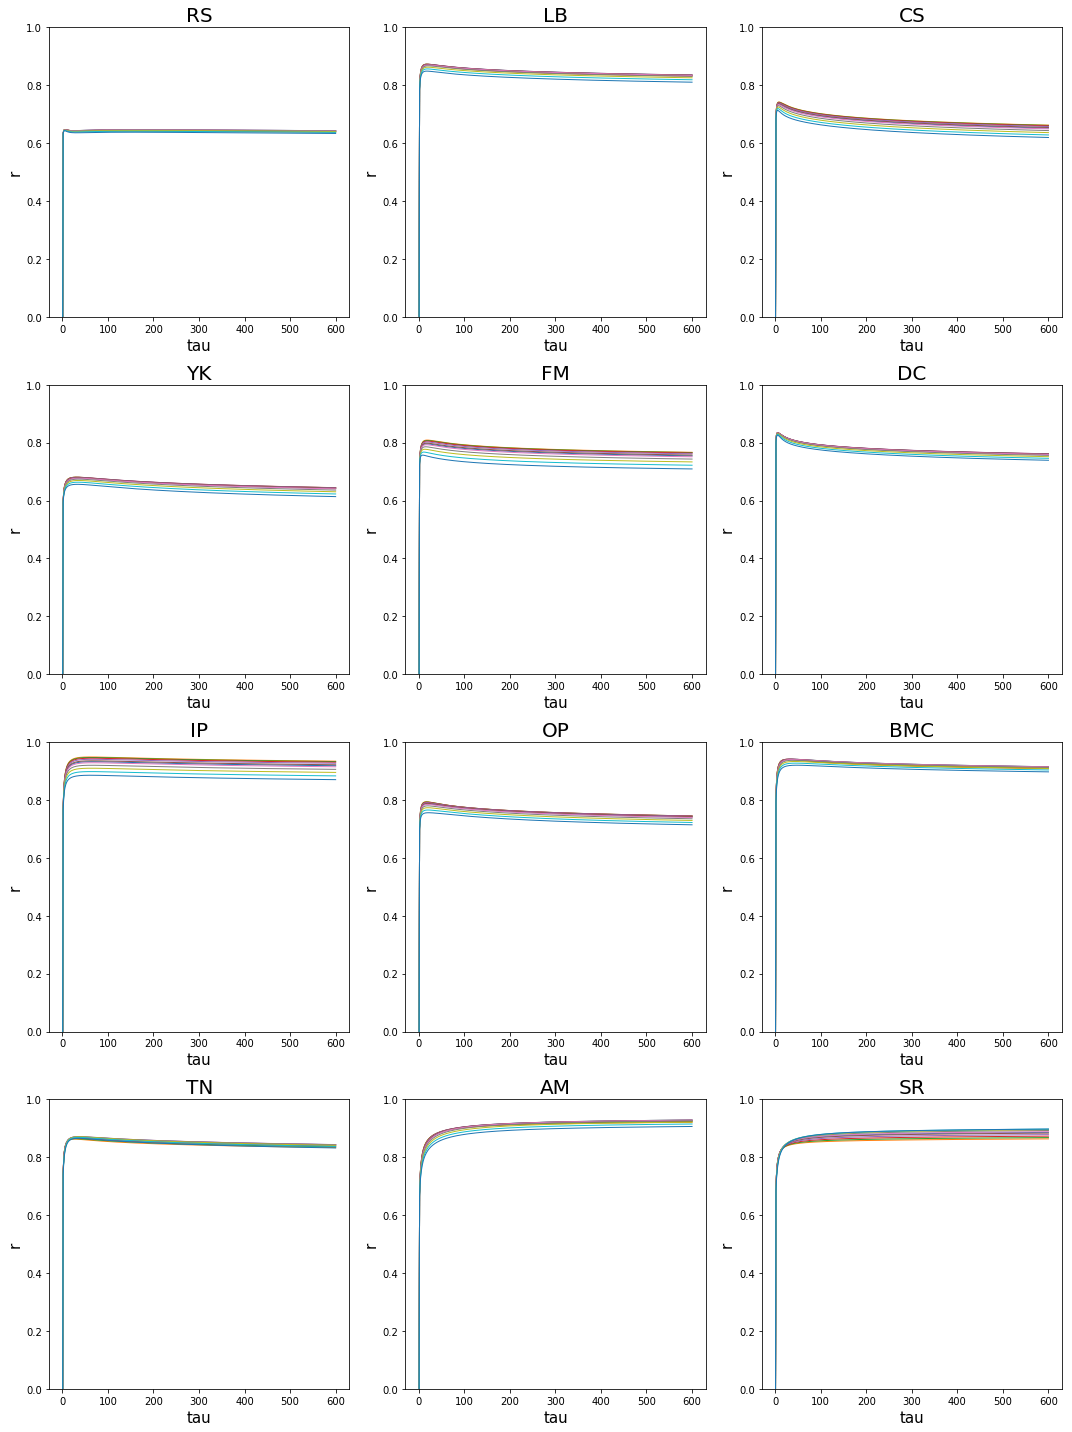

In [11]:
nb_suj = len(set(Full.sujet))


fig, ax = plt.subplots(4,3,figsize=(3*5,4*5))


r_k_s, h_k_s = {}, {}
for num_s, s in enumerate(list(set(Full.sujet))):
    print(s, end=' ')
    
    a = num_s//3
    b = num_s%3
    
    bet = Full['results'][Full.sujet==s].values.tolist()
    x = np.array(Full['bino'][Full.sujet==s].values.tolist())

    r_k, h_k = [], []
    for k in range(11) : r_k.append([]) ; h_k.append([])
    
    for num, k in enumerate(np.logspace(-1, 1, 10, base=2)) :
        
        r_bet_l, r_bet_ = recording['r_bet_k'][s][k], recording['r_bet_k'][s]['sslogit']
        
        if num==0 : ax[a][b].plot(1/list_h, r_bet_, lw=1)
        ax[a][b].plot(1/list_h, r_bet_l, lw=1)
    ax[a][b].set_title(s, fontsize=20)
    ax[a][b].set_ylim(0,1)
    ax[a][b].set_ylabel('r', fontsize=15)
    ax[a][b].set_xlabel('tau', fontsize=15)
plt.tight_layout()
        

RS LB CS YK FM DC IP OP BMC TN AM SR 

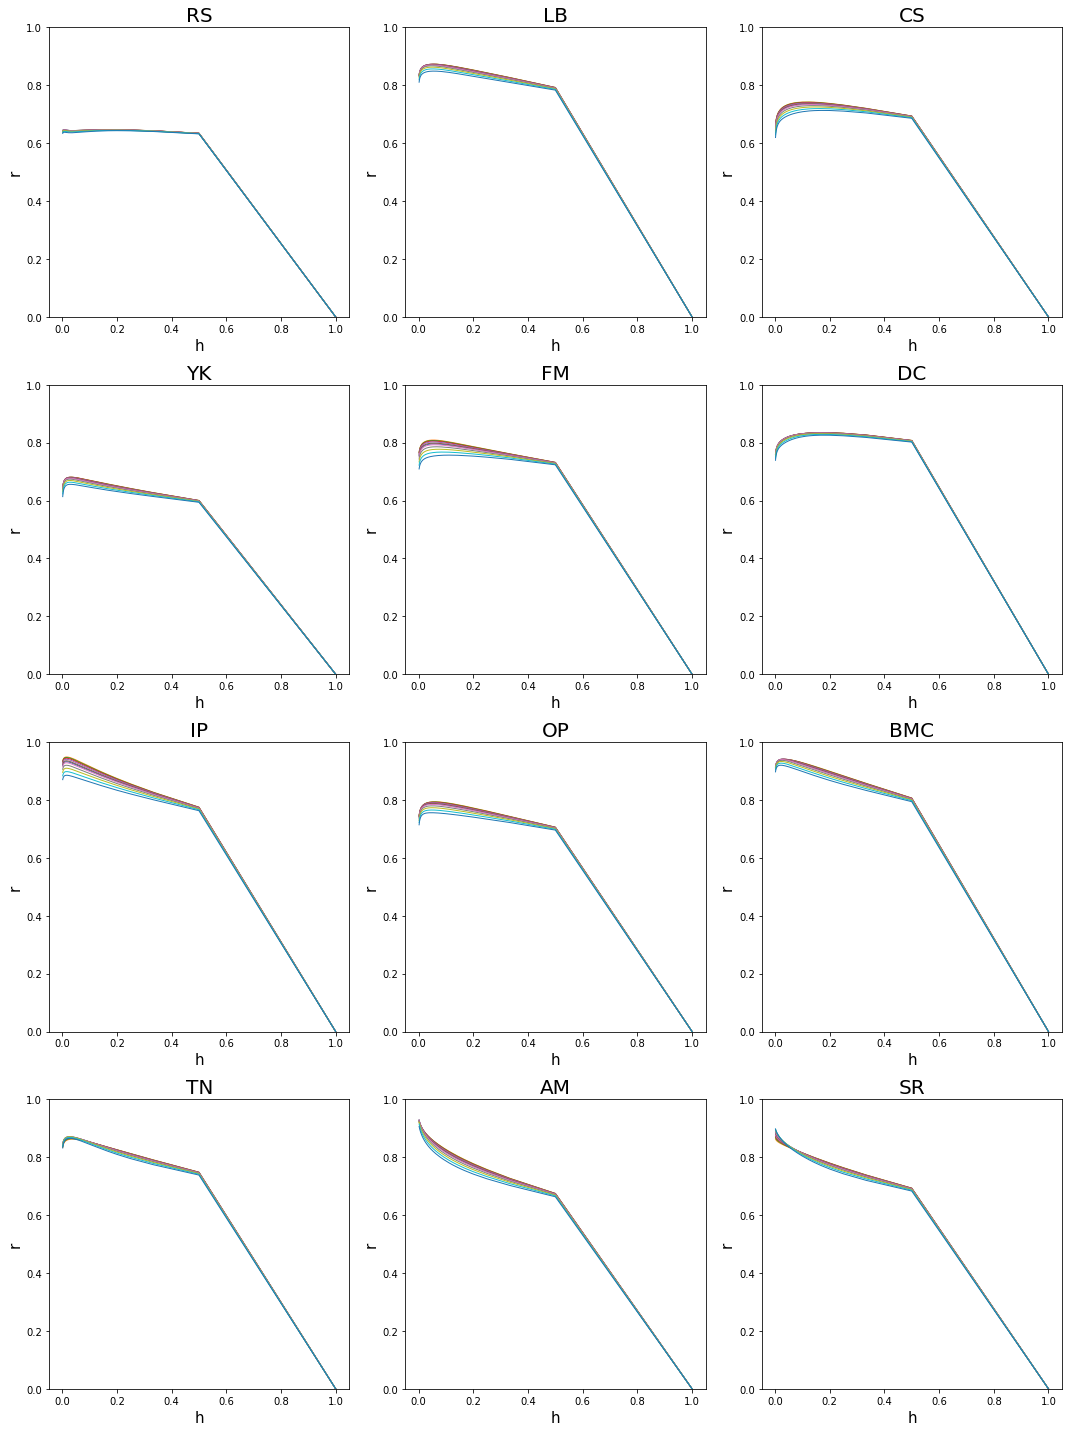

In [12]:
nb_suj = len(set(Full.sujet))


fig, ax = plt.subplots(4,3,figsize=(3*5,4*5))


r_k_s, h_k_s = {}, {}
for num_s, s in enumerate(list(set(Full.sujet))):
    print(s, end=' ')
    
    a = num_s//3
    b = num_s%3
    
    bet = Full['results'][Full.sujet==s].values.tolist()
    x = np.array(Full['bino'][Full.sujet==s].values.tolist())

    r_k, h_k = [], []
    for k in range(11) : r_k.append([]) ; h_k.append([])
    
    for num, k in enumerate(np.logspace(-1, 1, 10, base=2)) :
        
        r_bet_l, r_bet_ = recording['r_bet_k'][s][k], recording['r_bet_k'][s]['sslogit']
        
        if num==0 : ax[a][b].plot(list_h, r_bet_, lw=1)
        ax[a][b].plot(list_h, r_bet_l, lw=1)
    ax[a][b].set_title(s, fontsize=20)
    ax[a][b].set_ylim(0,1)
    ax[a][b].set_ylabel('r', fontsize=15)
    ax[a][b].set_xlabel('h', fontsize=15)
plt.tight_layout()